In [1]:

from dotenv import load_dotenv
load_dotenv()
from langchain_cerebras import ChatCerebras
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import SystemMessage

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.store.memory import InMemoryStore   # InMemoryStore(BaseStore)
from langgraph.store.base import BaseStore

c:\Users\91830\anaconda3\envs\lgenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ----------------------------
# 1) Create LTM store + seed memories (done BEFORE running the graph)
# ----------------------------
store = InMemoryStore()  # currently don't including sementic serach

user_id = "u1"

# Store user details as a single blob (simple for teaching)
# You can also split into multiple records; this keeps it easy.
user_details = ("user", user_id, "details")  # namespace
            
           # namespace   #unique key     # values
store.put(user_details, "profile_1", {"data": "Name: pankaj"})
store.put(user_details, "profile_2", {"data": "Profession: Jr Associate Ai Developer"})
store.put(user_details, "preference_1", {"data": "Prefers concise answers"})
store.put(user_details, "preference_2", {"data": "Likes examples in Python"})
store.put(user_details, "project_1", {"data": "Building MCP servers (Python-based project)"})

In [3]:
# ----------------------------
# 2) System prompt template (your prompt)
# ----------------------------
SYSTEM_PROMPT_TEMPLATE = """You are a helpful assistant with memory capabilities.
If user-specific memory is available, use it to personalize 
your responses based on what you know about the user.

Your goal is to provide relevant, friendly, and tailored 
assistance that reflects the user’s preferences, context, and past interactions.

If the user’s name or relevant personal context is available, always personalize your responses by:
    – Always Address the user by name (e.g., "Sure, Pankaj...") when appropriate
    – Referencing known projects, tools, or preferences (e.g., "your MCP  server python based project")
    – Adjusting the tone to feel friendly, natural, and directly aimed at the user

Avoid generic phrasing when personalization is possible. For example, instead of "In TypeScript apps..." 
say "Since your project is built with TypeScript..."

Use personalization especially in:
    – Greetings and transitions
    – Help or guidance tailored to tools and frameworks the user uses
    – Follow-up messages that continue from past context

Always ensure that personalization is based only on known user details and not assumed.

In the end suggest 3 relevant further questions based on the current response and user profile

The user’s memory (which may be empty) is provided as: {user_details_content}
"""

In [4]:
# ----------------------------
# 3) Build graph: START -> chat -> END (read-only LTM)
# ----------------------------
llm = ChatCerebras(model='llama-3.3-70b')

In [13]:
def chat_node(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id=config['configurable']['user_id']

    # Read-only: fetch user details memory (no writes)
    user_details= ('user', user_id, 'details')
    items=store.search(user_details)

    ## Convert memory items into a string blob for {user_details_content}
    # Keep it dead simple for teaching.
    if items: 
        user_details_content='\n'.join(f"-{it.value.get('data', '')}" for it in items)
    else: 
        user_details_content=""  # prompt says it may be empty

    system_prompt=SYSTEM_PROMPT_TEMPLATE.format(user_details_content=user_details_content)

    system_msg=SystemMessage(content=system_prompt)

    response=llm.invoke([system_msg]+state['messages'])

    return {'messages': [response]}

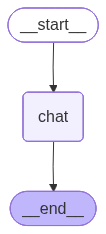

In [14]:
builder=StateGraph(MessagesState)


# internally MessageState
# class MessagesState(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

builder.add_node('chat', chat_node)

builder.add_edge(START, 'chat')
builder.add_edge('chat', END)

graph=builder.compile(store=store)

graph

In [15]:

# ----------------------------
# 4) Run it (provide user_id in config)
# ----------------------------

config={'configurable': {'user_id': 'u1'}}
result=graph.invoke(
    {'messages': [{'role': 'user', 'content': 'Explain gen ai in simple terms'}]}, 
    config=config
)

print(result['messages'][-1].content)

Sure, Pankaj. As a Jr Associate AI Developer, you're likely familiar with AI concepts. Generative AI (Gen AI) is a type of AI that can create new content, like images, videos, music, or text, based on patterns it learned from existing data. Think of it like a very advanced version of auto-complete, but instead of just suggesting words, it can generate entire pieces of content.

For example, in Python, you could use a library like TensorFlow to build a Gen AI model that generates new images of animals based on a dataset of existing animal pictures.

Here's a simple Python example using TensorFlow and Keras:
```python
from tensorflow import keras
from tensorflow.keras import layers

# Define a simple Gen AI model
model = keras.Sequential([
    layers.Dense(128, input_shape=(100,)),
    layers.LeakyReLU(),
    layers.Dense(784, activation='tanh')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
```
This model can generate new images based on random input 